In [1]:
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    mean_absolute_percentage_error
)
from sktime.performance_metrics.forecasting import (
    mean_squared_percentage_error,
    median_absolute_percentage_error,
    mean_relative_absolute_error,
    median_relative_absolute_error
)

In [2]:
plt.rc('font', family='Malgun Gothic')  # 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

In [3]:
# 데이터 불러오기
df = pd.read_csv(r"C:\Users\james\J_Data_Lab\Project_KTX\data\ktx_prep_v3_2.csv")

In [4]:
def eda_basic_info(df, df_name="DataFrame"):
    print(f"\n===== {df_name} =====")
    print("Head (5 rows):")
    display(df.head())
    
    print("\nInfo:")
    print(df.info())
    
    print("\nDescribe (numeric):")
    display(df.describe())
    
    print("\nNull counts:")
    print(df.isnull().sum())
    
    print("="*40)

In [5]:
eda_basic_info(df, "df")


===== df =====
Head (5 rows):


,년도,월,주운행선,공급차량수,공급좌석합계수,승차수입금액,승차인원수,승차연인거리,좌석거리,상행_KTX,...,하행_KTX-산천,하행_KTX-호남,공휴일여부,평일,주말,korea_cpi,승차인원수_lag1,승차인원수_lag2,승차인원수_lag3,KSVKOSPI
0,2015,1,0,69372,3543395,128049178500,3667299,9748048608,14822262064,1868.0,...,184.0,0.0,1,17,14,0.008,0.0,0.0,0.0,13.544286
1,2015,1,1,7916,390579,13159939900,382611,1026120838,1716874542,151.0,...,155.0,0.0,1,17,14,0.008,0.0,0.0,0.0,13.544286
2,2015,1,3,4572,205635,5769306100,205812,537179861,885576340,3.0,...,279.0,0.0,1,17,14,0.008,0.0,0.0,0.0,13.544286
3,2015,1,4,15824,764029,14696394300,548361,1341555631,2981704029,248.0,...,417.0,0.0,1,17,14,0.008,0.0,0.0,0.0,13.544286
4,2015,2,0,63270,3245162,121361834100,3422455,9164774985,13580749259,1709.0,...,170.0,0.0,3,16,12,0.005,3667299.0,0.0,0.0,12.445882



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472 entries, 0 to 471
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   년도          472 non-null    int64  
 1   월           472 non-null    int64  
 2   주운행선        472 non-null    int64  
 3   공급차량수       472 non-null    int64  
 4   공급좌석합계수     472 non-null    int64  
 5   승차수입금액      472 non-null    int64  
 6   승차인원수       472 non-null    int64  
 7   승차연인거리      472 non-null    int64  
 8   좌석거리        472 non-null    int64  
 9   상행_KTX      472 non-null    float64
 10  상행_KTX-산천   472 non-null    float64
 11  상행_KTX-호남   472 non-null    float64
 12  하행_KTX      472 non-null    float64
 13  하행_KTX-산천   472 non-null    float64
 14  하행_KTX-호남   472 non-null    float64
 15  공휴일여부       472 non-null    int64  
 16  평일          472 non-null    int64  
 17  주말          472 non-null    int64  
 18  korea_cpi   472 non-null    float64
 19  승차인원수_lag1  472 non-nu

,년도,월,주운행선,공급차량수,공급좌석합계수,승차수입금액,승차인원수,승차연인거리,좌석거리,상행_KTX,...,하행_KTX-산천,하행_KTX-호남,공휴일여부,평일,주말,korea_cpi,승차인원수_lag1,승차인원수_lag2,승차인원수_lag3,KSVKOSPI
count,472.000000,472.000000,472.000000,472.000000,4.720000e+02,4.720000e+02,4.720000e+02,4.720000e+02,4.720000e+02,472.000000,...,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000,4.720000e+02,4.720000e+02,4.720000e+02,472.000000
mean,2019.341102,6.368644,2.000000,24718.875000,1.276590e+06,3.677161e+10,1.119514e+06,2.707561e+09,5.032241e+09,556.332627,...,242.692797,70.203390,1.343220,17.345339,13.029661,0.020780,1.105657e+06,1.091861e+06,1.078700e+06,17.054408
std,2.727575,3.500032,1.535151,20487.290443,1.079489e+06,3.586957e+10,1.023866e+06,2.618874e+09,4.479704e+09,608.275661,...,116.033604,79.464723,1.207196,1.235283,1.156157,0.016403,1.023903e+06,1.023784e+06,1.024084e+06,5.345289
min,2015.000000,1.000000,0.000000,1264.000000,6.339000e+04,1.508467e+09,5.113300e+04,1.098566e+08,2.363754e+08,0.000000,...,36.000000,0.000000,0.000000,3.000000,1.000000,-0.004000,0.000000e+00,0.000000e+00,0.000000e+00,10.748500
25%,2017.000000,3.000000,1.000000,10251.000000,5.235342e+05,1.488894e+10,4.908502e+05,1.111639e+09,2.178341e+09,180.000000,...,154.750000,3.250000,0.000000,16.000000,12.000000,0.007000,4.821065e+05,4.575785e+05,4.515820e+05,13.539524
50%,2019.000000,6.000000,2.000000,12892.000000,6.555165e+05,1.986342e+10,6.499620e+05,1.489556e+09,2.570519e+09,201.000000,...,230.000000,39.000000,1.000000,17.000000,13.000000,0.015000,6.425500e+05,6.295270e+05,6.200950e+05,15.544737
75%,2022.000000,9.000000,3.000000,23698.500000,1.223219e+06,3.191302e+10,1.007911e+06,2.230958e+09,4.044225e+09,476.500000,...,308.500000,112.250000,2.000000,18.000000,14.000000,0.032000,1.003733e+06,9.915388e+05,9.888895e+05,18.293333
max,2024.000000,12.000000,4.000000,69858.000000,3.592956e+06,1.350760e+11,3.894486e+06,1.027178e+10,1.492484e+10,3220.000000,...,744.000000,372.000000,4.000000,19.000000,15.000000,0.063000,3.894486e+06,3.894486e+06,3.894486e+06,47.443636



Null counts:
년도            0
월             0
주운행선          0
공급차량수         0
공급좌석합계수       0
승차수입금액        0
승차인원수         0
승차연인거리        0
좌석거리          0
상행_KTX        0
상행_KTX-산천     0
상행_KTX-호남     0
하행_KTX        0
하행_KTX-산천     0
하행_KTX-호남     0
공휴일여부         0
평일            0
주말            0
korea_cpi     0
승차인원수_lag1    0
승차인원수_lag2    0
승차인원수_lag3    0
KSVKOSPI      0
dtype: int64


In [6]:
# 모델 초기화
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42)
}

# 평가 지표 계산 함수
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mspe = np.mean(np.square((y_true - y_pred) / y_true)) * 100
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    medae = median_absolute_error(y_true, y_pred)
    medape = np.median(np.abs((y_true - y_pred) / y_true)) * 100
    return [mse, rmse, mspe, mae, mape, medae, medape]

# 결과 저장
results = []
all_preds = {}

In [7]:
for name, model in models.items():
    for line in df['주운행선'].unique():
        # 주운행선별 데이터 분리
        df_line = df[df['주운행선'] == line]

        # 입력 변수 및 타겟 설정
        X = df_line.drop(['승차인원수', '년도', '월'], axis=1)
        y = df_line['승차인원수']

        # 데이터 스케일링
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)

        # 데이터 분할
        if len(X) < 2:  # 데이터가 적으면 스킵
            continue

        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        metrics = calculate_metrics(y_test, y_pred)
        results.append([name, line] + metrics)

        # 실제값 및 예측값 저장
        if name not in all_preds:
            all_preds[name] = {}
        all_preds[name][line] = (
            df_line.loc[y_test.index, ['년도', '월']],  # 날짜 정보
            y_test.values,  # 실제값
            y_pred  # 예측값
        )

# 결과 표 출력
columns = ['Model', 'Line', 'MSE', 'RMSE', 'MSPE', 'MAE', 'MAPE', 'MedAE', 'MedAPE']
results_df = pd.DataFrame(results, columns=columns)

# 주운행선 매핑 적용
line_mapping = {
    0: '경부선',
    1: '경전선',
    2: '동해선',
    3: '전라선',
    4: '호남선'
}
results_df['Line'] = results_df['Line'].map(line_mapping)
results_df

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of data points in the train set: 88, number of used features: 19
[LightGBM] [Info] Start training from score 2894389.352273
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

,Model,Line,MSE,RMSE,MSPE,MAE,MAPE,MedAE,MedAPE
0,RandomForest,경부선,6.373584e+09,79834.727223,0.071430,60600.531739,2.267912,55454.050000,2.003907
1,RandomForest,경전선,1.986635e+08,14094.802575,0.127362,11671.011304,2.832703,11484.620000,2.459838
2,RandomForest,전라선,7.679690e+07,8763.383869,0.053366,6852.095652,1.747672,4858.660000,1.399996
3,RandomForest,호남선,2.613542e+08,16166.451444,0.061781,13649.826522,1.986740,12571.690000,1.582276
4,RandomForest,동해선,1.625349e+10,127489.158330,617.534952,60300.560000,103.021192,9525.805000,1.767003
5,XGBoost,경부선,6.369942e+09,79811.914043,0.098175,60894.173913,2.452496,53060.750000,1.905713
6,XGBoost,경전선,1.966817e+08,14024.324196,0.129050,10850.520380,2.719233,7985.062500,1.913010
7,XGBoost,전라선,9.599842e+07,9797.878394,0.058929,6829.572011,1.684252,3804.437500,0.968892
8,XGBoost,호남선,2.994914e+08,17305.818789,0.062595,14975.637228,2.099942,15574.187500,2.051846
9,XGBoost,동해선,1.197546e+10,109432.465010,454.678492,51121.166667,88.279463,8525.250000,1.540212


In [8]:
# Best Model 선정
best_models = results_df.loc[results_df.groupby('Line')['RMSE'].idxmin()]
print("Best Models by Line:")
best_models

Best Models by Line:


,Model,Line,MSE,RMSE,MSPE,MAE,MAPE,MedAE,MedAPE
5,XGBoost,경부선,6.369942e+09,79811.914043,0.098175,60894.173913,2.452496,53060.7500,1.905713
6,XGBoost,경전선,1.966817e+08,14024.324196,0.129050,10850.520380,2.719233,7985.0625,1.913010
9,XGBoost,동해선,1.197546e+10,109432.465010,454.678492,51121.166667,88.279463,8525.2500,1.540212
2,RandomForest,전라선,7.679690e+07,8763.383869,0.053366,6852.095652,1.747672,4858.6600,1.399996
3,RandomForest,호남선,2.613542e+08,16166.451444,0.061781,13649.826522,1.986740,12571.6900,1.582276


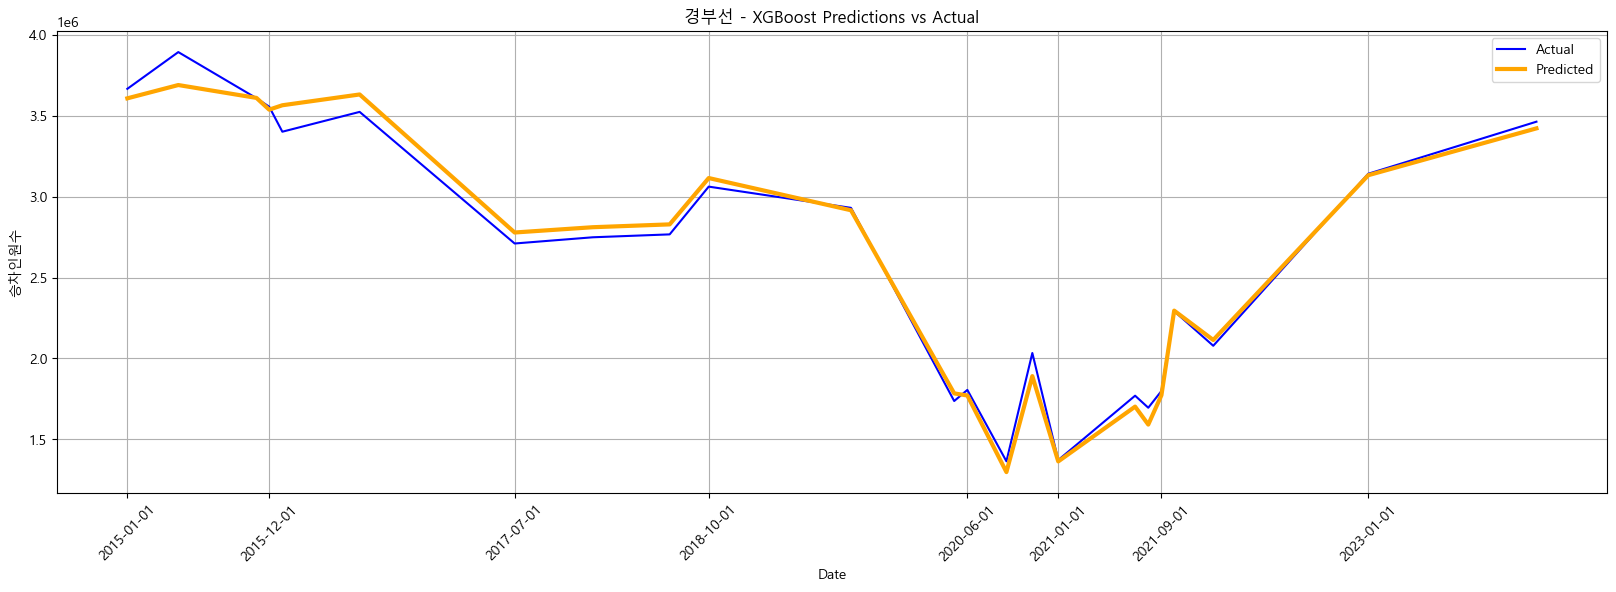

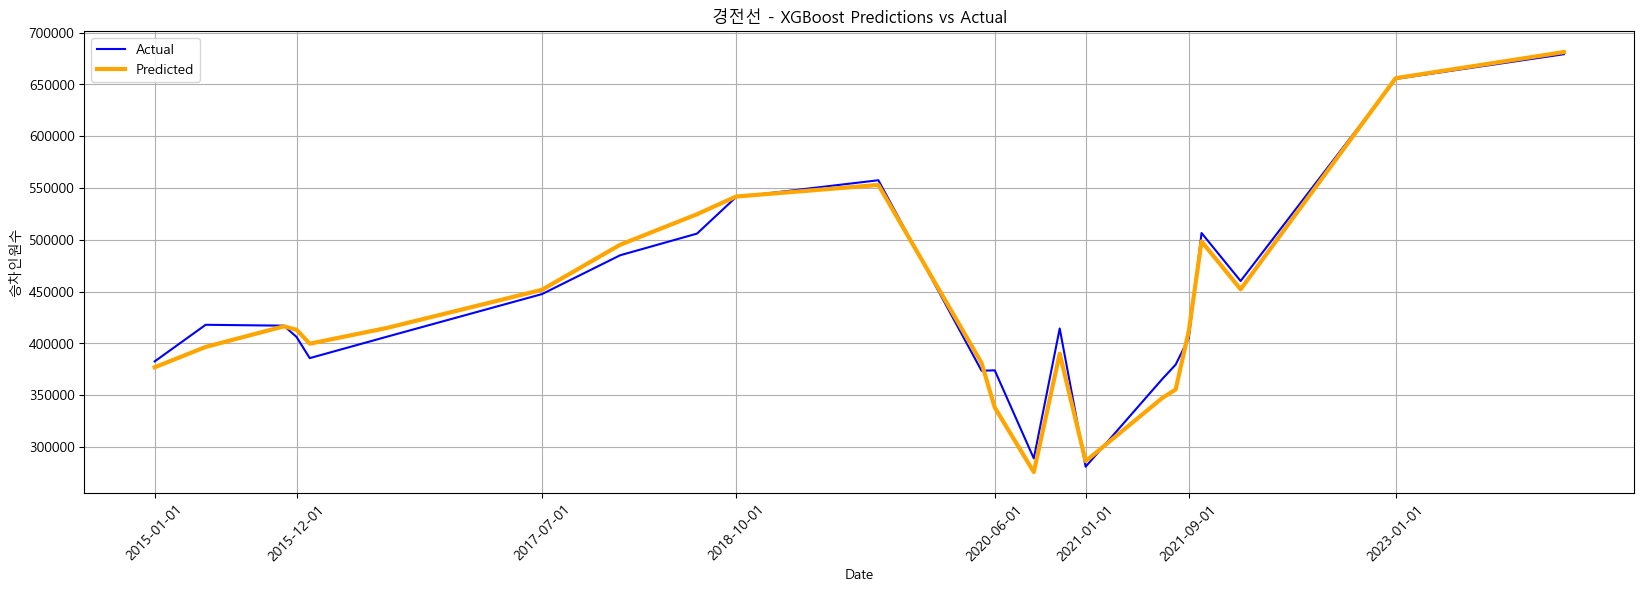

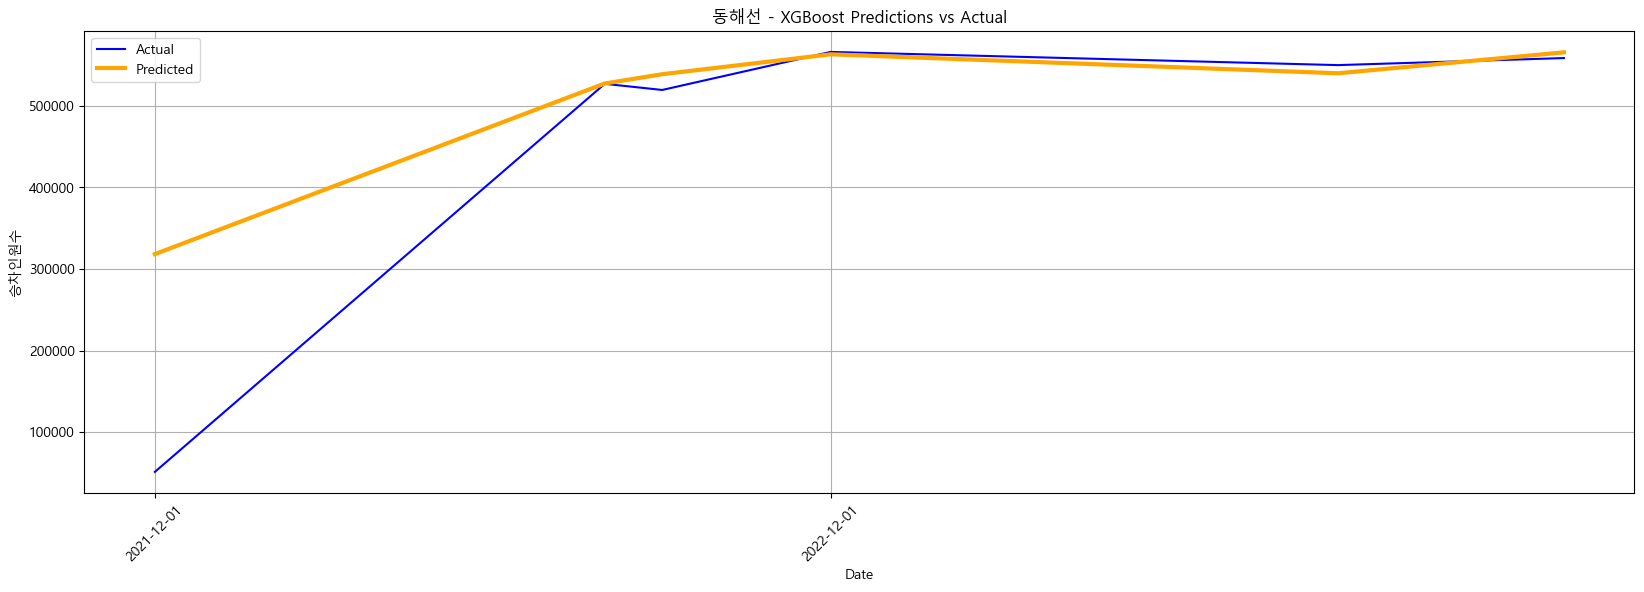

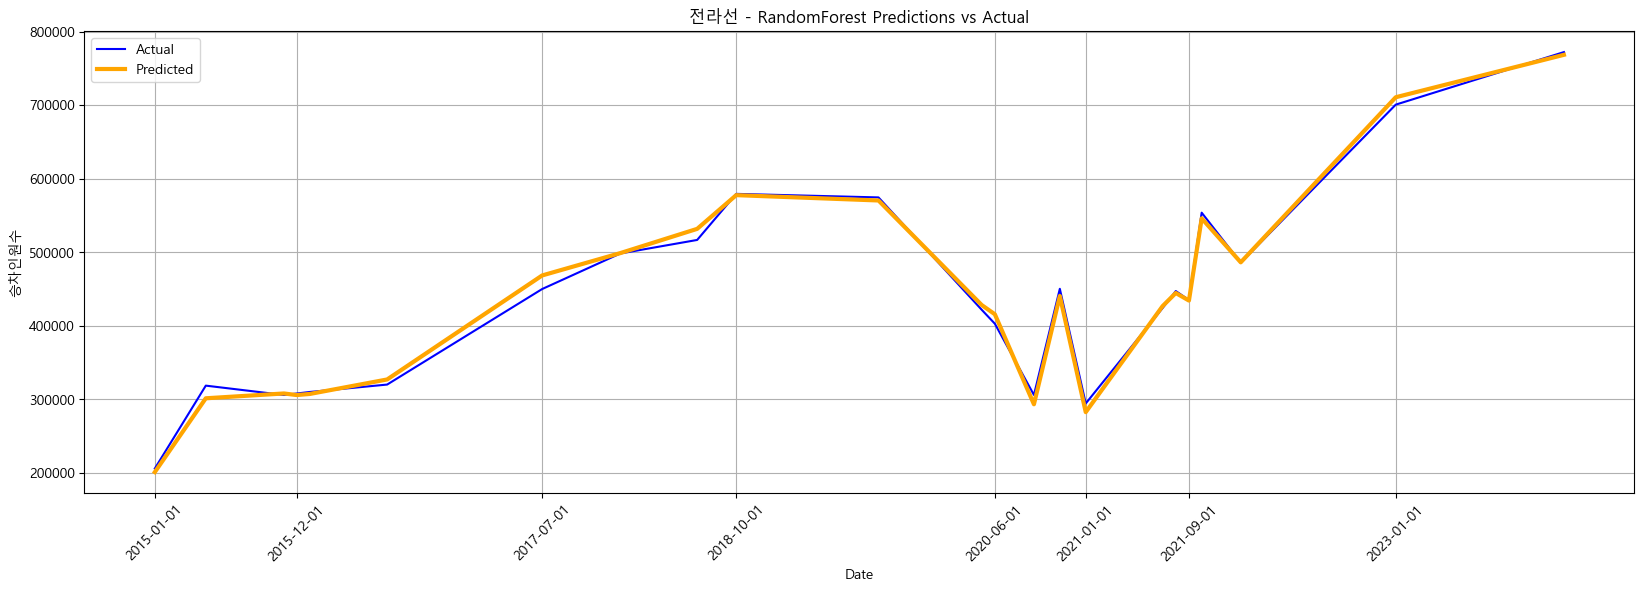

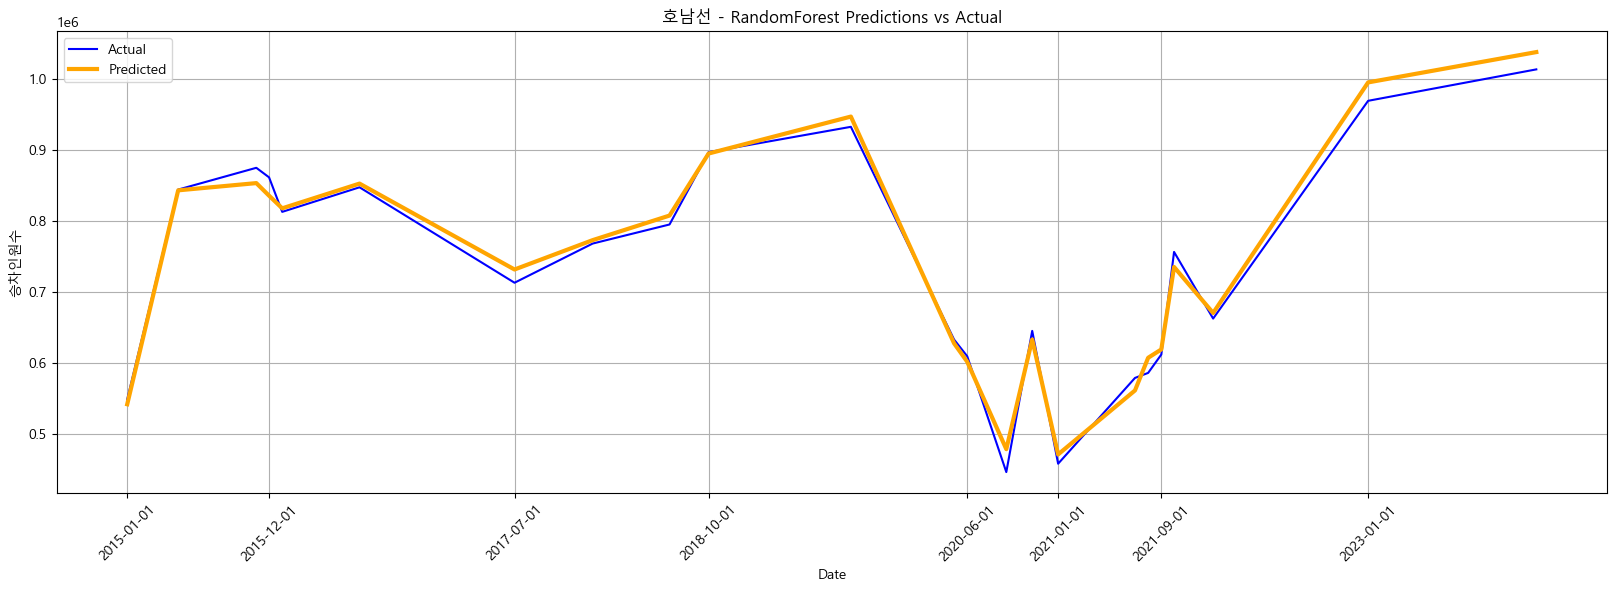

In [9]:
# 시각화
for index, row in best_models.iterrows():
    model_name = row['Model']
    line = row['Line']
    line_code = list(line_mapping.keys())[list(line_mapping.values()).index(line)]
    dates, y_test, y_pred = all_preds[model_name][line_code]

    # 시간 축 생성 및 정렬
    dates = pd.to_datetime(dates['년도'].astype(str) + '-' + dates['월'].astype(str))
    sorted_dates = dates.sort_values()
    y_test = y_test[np.argsort(dates)]
    y_pred = y_pred[np.argsort(dates)]

    plt.figure(figsize=(20, 6))
    plt.plot(sorted_dates, y_test, label='Actual', color='blue')
    plt.plot(sorted_dates, y_pred, label='Predicted', color='orange', linewidth=3)
    plt.title(f'{line} - {model_name} Predictions vs Actual')
    plt.xlabel('Date')
    plt.ylabel('승차인원수')
    plt.xticks(sorted_dates[::3], rotation=45)  # 3개월 단위 표시
    plt.legend()
    plt.grid(True)
    plt.show()


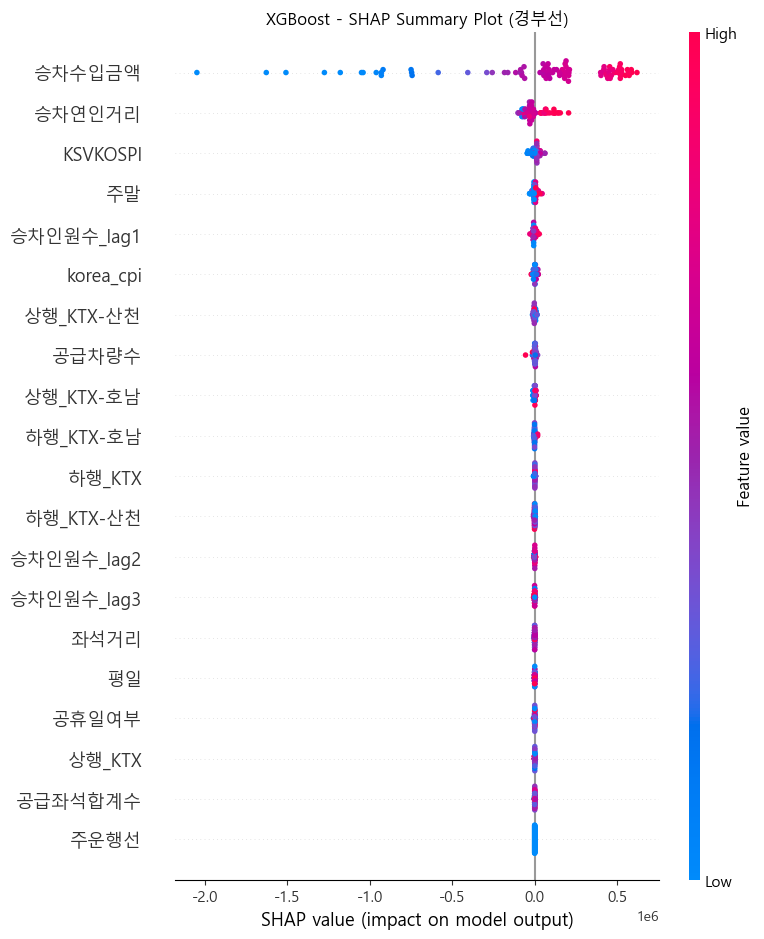

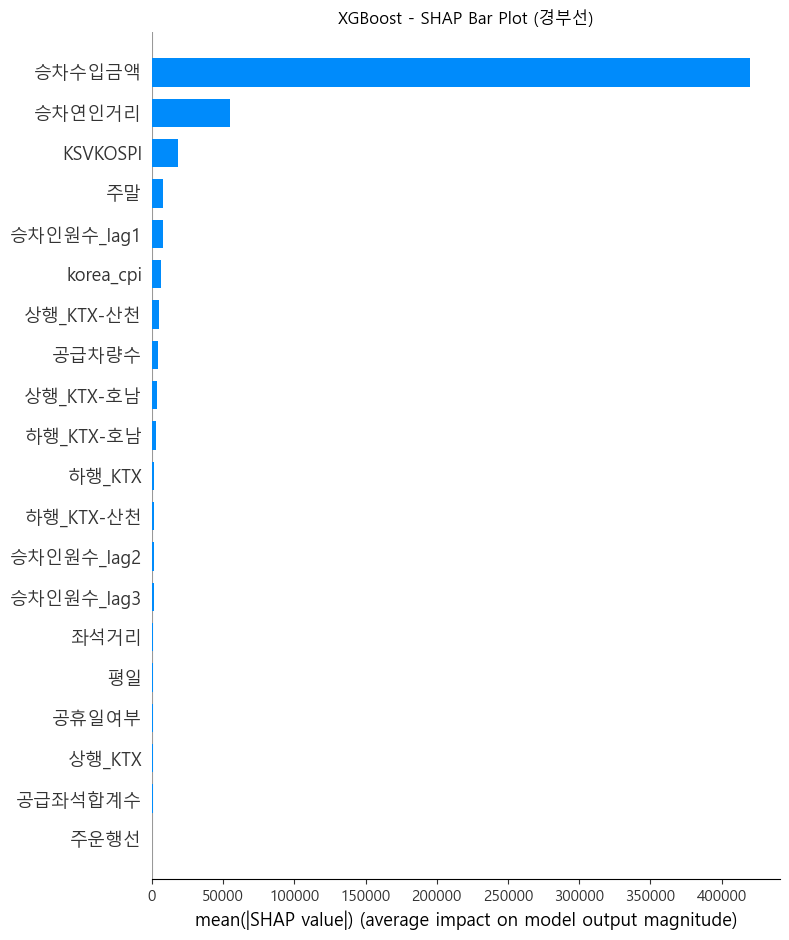

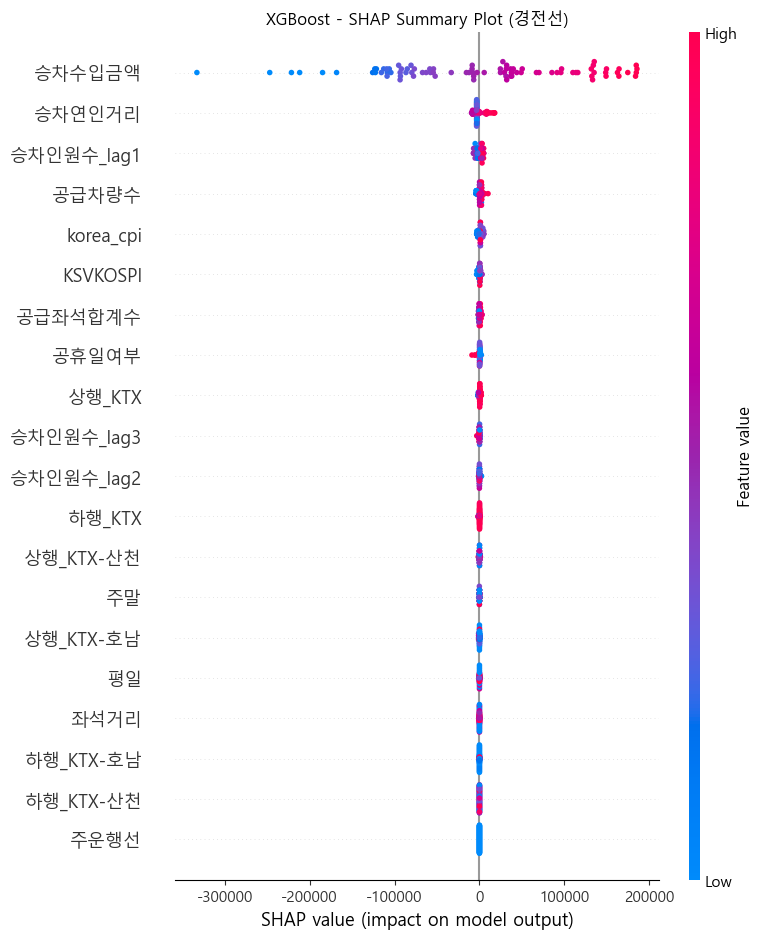

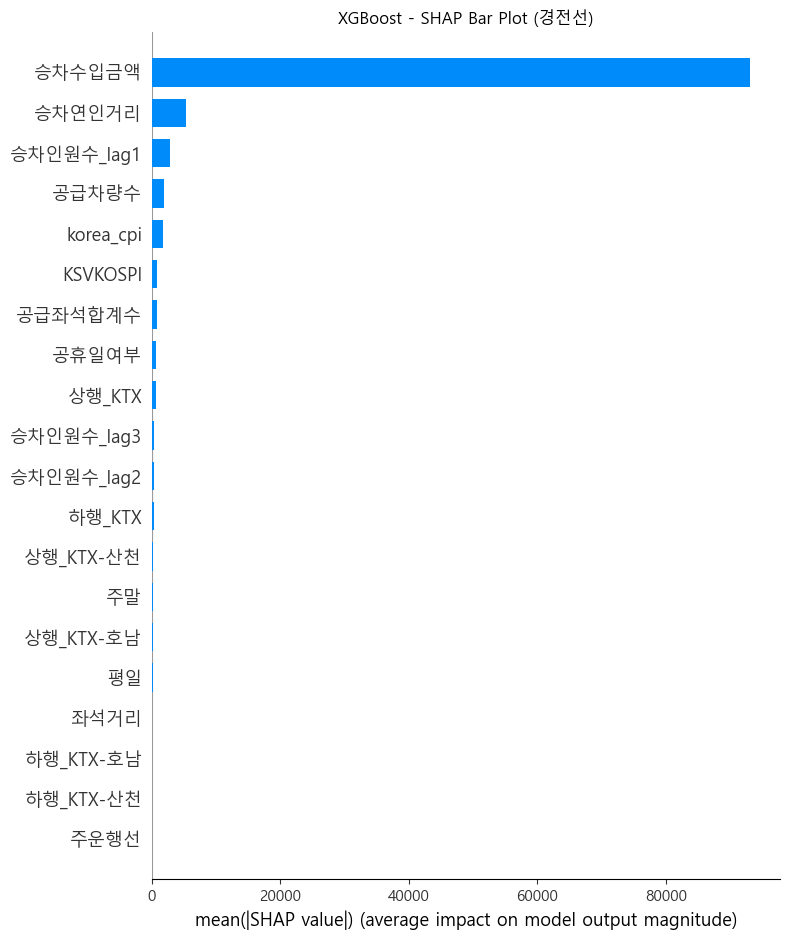

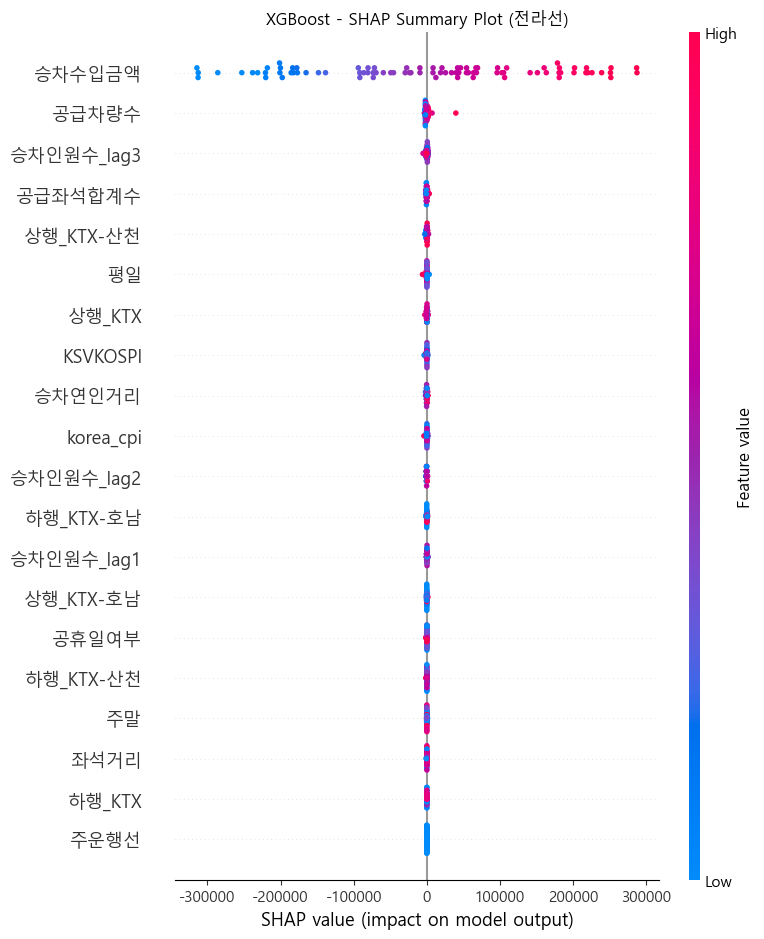

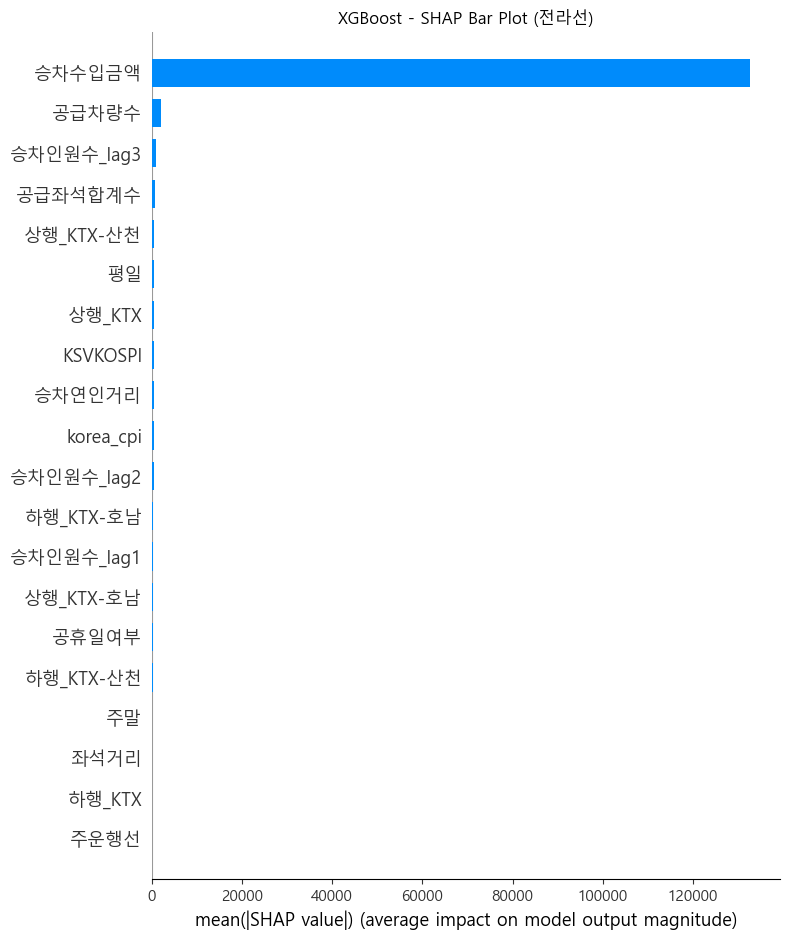

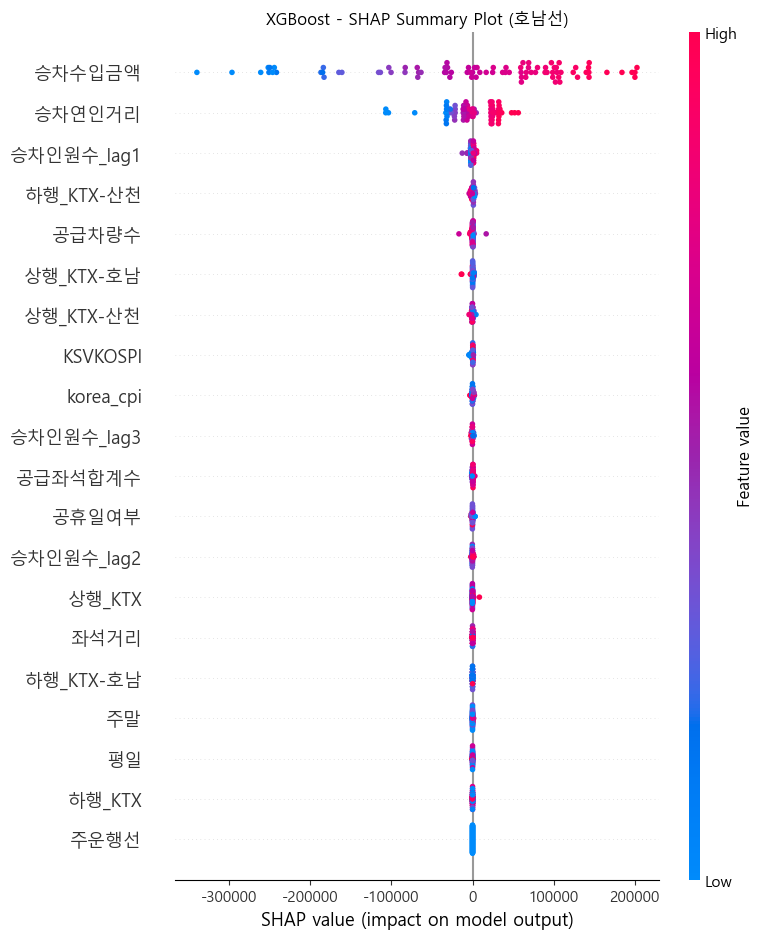

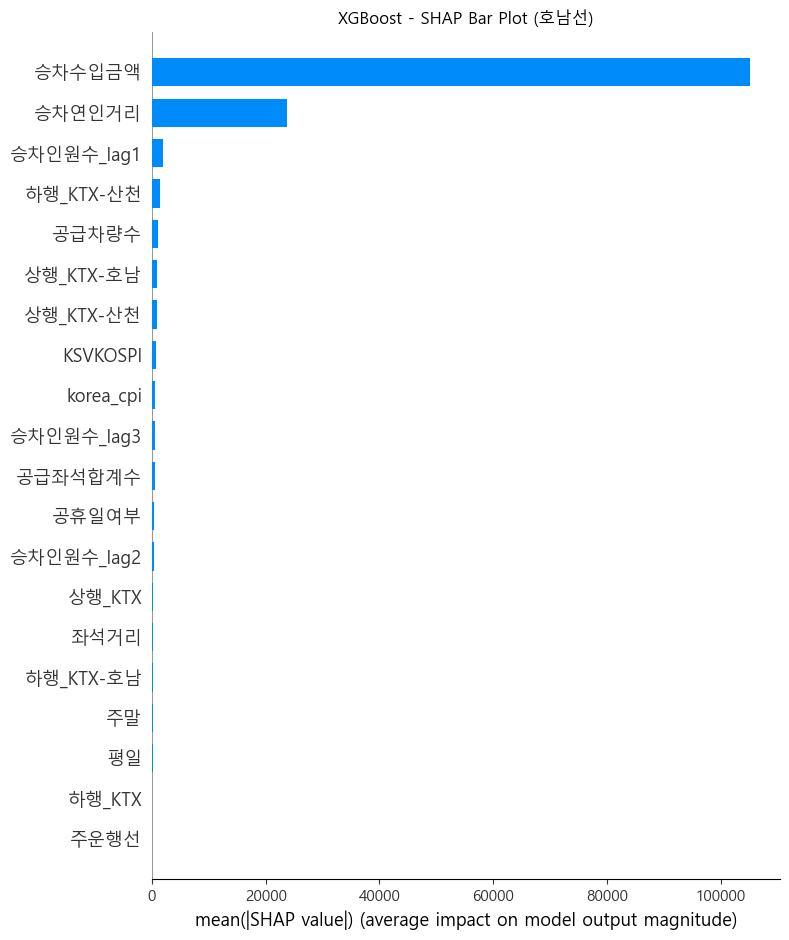

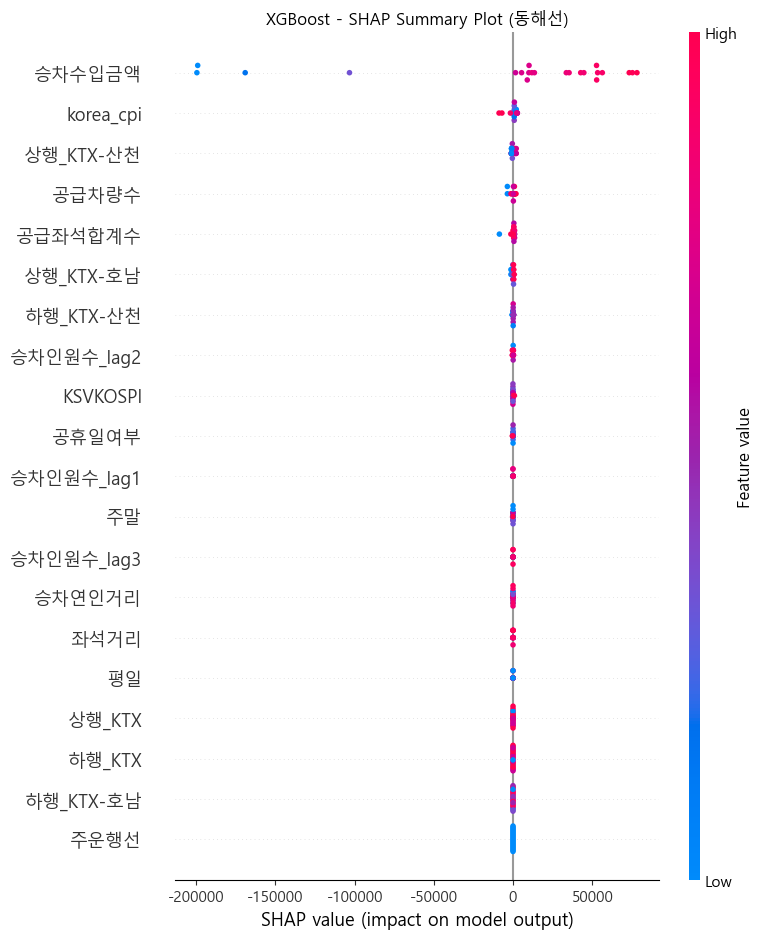

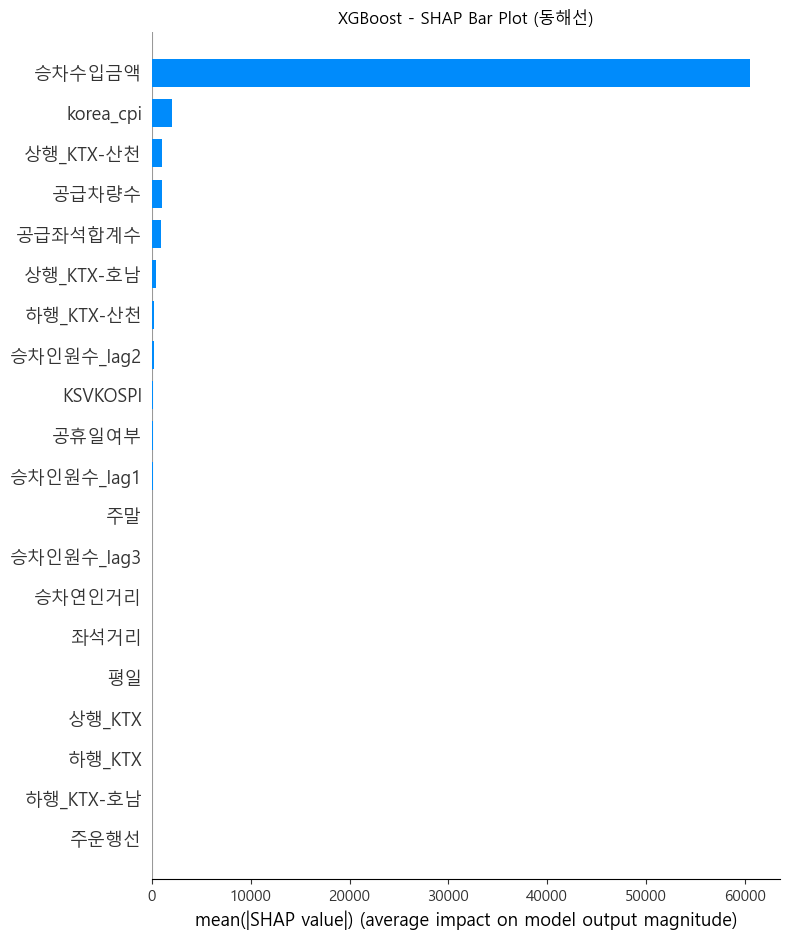

In [10]:
# SHAP 분석 함수
def shap_analysis_xgb(model, X_train, feature_names, line_name):
    # XGBoost 모델에 특화된 TreeExplainer 사용
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)

    # 특징 중요도 요약 플롯
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_train, feature_names=feature_names, show=False)
    plt.title(f'XGBoost - SHAP Summary Plot ({line_name})')
    plt.tight_layout()
    plt.show()

    # 특징 중요도 Bar Plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_train, feature_names=feature_names, plot_type='bar', show=False)
    plt.title(f'XGBoost - SHAP Bar Plot ({line_name})')
    plt.tight_layout()
    plt.show()

# XGBoost에 대한 SHAP 분석 실행
model = models['XGBoost']  # XGBoost 모델 선택
for line in df['주운행선'].unique():
    # 주운행선 데이터 분리 및 이름 매핑
    df_line = df[df['주운행선'] == line]
    line_name = line_mapping.get(line, 'Unknown')  # 매핑 적용

    # 입력 변수 및 타겟 설정
    X = df_line.drop(['승차인원수', '년도', '월'], axis=1)
    y = df_line['승차인원수']

    # 데이터 스케일링
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )

    # 모델 학습
    model.fit(X_train, y_train)

    # SHAP 분석 실행
    shap_analysis_xgb(model, X_train, feature_names=X.columns, line_name=line_name)